In [1]:
import pandas as pd
import os


In [2]:
filenames = os.listdir(os.getcwd())
csv_filenames = [f for f in filenames if f.endswith('csv')]

In [3]:

all_data = []
for filename in csv_filenames:
    # Step 1: Read the first two rows to get column names and units
    first_rows = pd.read_csv(filename, nrows=1)
    
    # Step 2: Combine column names with units
    columns_with_units = [f'{col} {unit}' for col, unit in zip(first_rows.columns, first_rows.iloc[0])]
    
    # Step 3: Read the CSV file, skipping the first two rows and applying the new column names
    data = pd.read_csv(filename, skiprows=2, names=first_rows.columns)
    
    # Step 4: Process the filenames to extract specimen, conductivity, and sample number
    # Assuming filename format is 'specimen_conductivity_samplenumber.csv'
    specimen, conductivity, sample_number = filename.replace('.csv', '').split('_')
    # Add a new column to the DataFrame for specimen, conductivity, and sample number
    data['Specimen'] = specimen
    data['Conductivity'] = conductivity
    data['SampleNumber'] = int(sample_number)
    
    # Append the DataFrame to our list of all data
    all_data.append(data)

# Combine all data into a single DataFrame
combined_data = pd.concat(all_data, ignore_index=True)

In [4]:
label_dict = {"pristine": "PG", "hmwg":"CG", "g60":"GG", "conductive":"C", "nonconductive":"NC"}

Axes(0.125,0.53;0.227941x0.35)
Axes(0.125,0.11;0.227941x0.35)
Axes(0.398529,0.53;0.227941x0.35)
Axes(0.398529,0.11;0.227941x0.35)
Axes(0.672059,0.53;0.227941x0.35)
Axes(0.672059,0.11;0.227941x0.35)


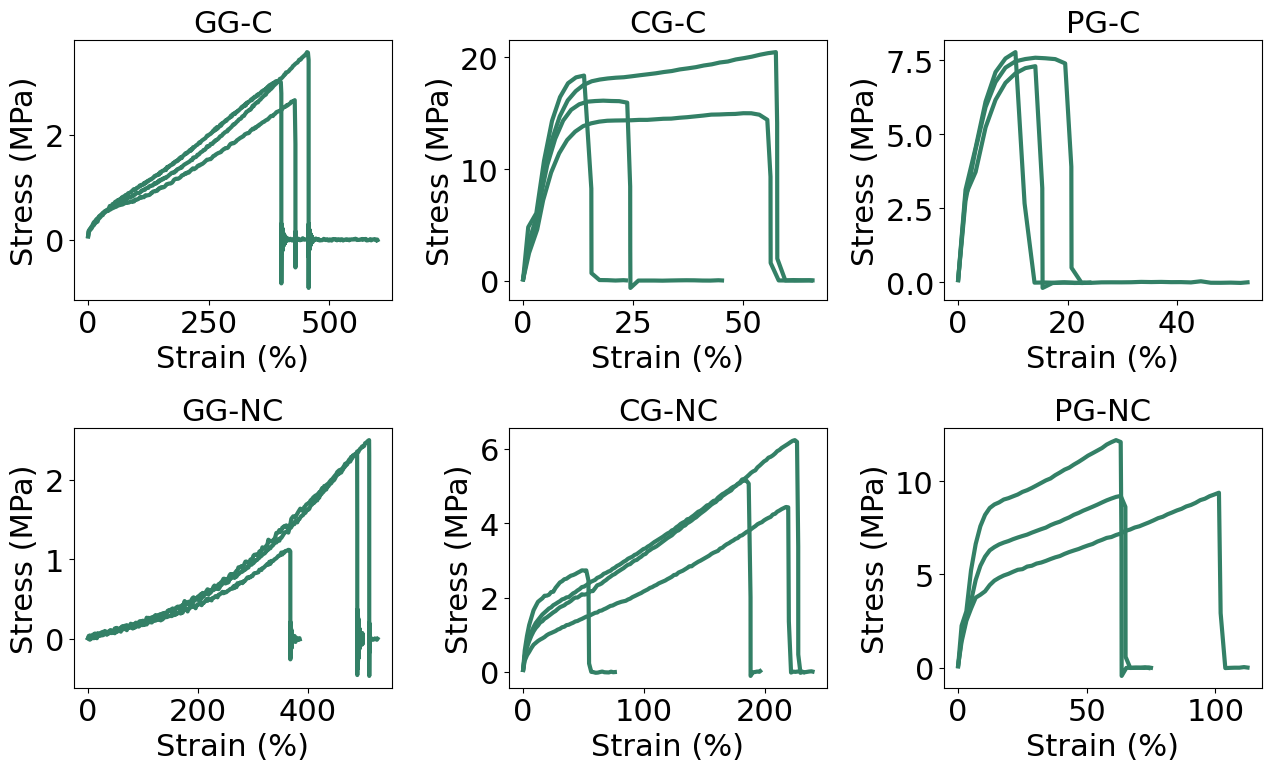

In [5]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 16})
# Get unique combinations of specimen and conductivity
unique_combinations = combined_data.drop_duplicates(subset=['Specimen', 'Conductivity'])

# Setup the plot - assuming a 3x2 grid for 6 plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 8))
axes = axes.flatten()  # Flatten to make it easier to iterate over
order = [0,3,1,4,2,5]
#order = [0,1,2,3,4,5]
for i, (index, row) in enumerate(unique_combinations.iterrows()):
    ax = axes[order[i]]
    print(ax)
    # Filter data for the current specimen and conductivity
    current_data = combined_data[(combined_data['Specimen'] == row['Specimen']) &
                                 (combined_data['Conductivity'] == row['Conductivity'])]
    
    # Plot stress vs. strain for each SampleNumber within this group
    for sample_number in np.sort(current_data['SampleNumber'].unique()):
        sample_data = current_data[current_data['SampleNumber'] == sample_number]
        ax.plot(sample_data['Strain']*100, sample_data['Stress'], label=f'Sample {sample_number}', color=(0.2, 0.5, 0.4), linewidth=3)
        
    ax.tick_params(labelsize=22)
    ax.set_title(f'{label_dict[row["Specimen"]]}-{label_dict[row["Conductivity"]]}', fontsize=22)
    ax.set_xlabel('Strain (%)', fontsize=22)
    ax.set_ylabel('Stress (MPa)', fontsize=22)
    #axes[i].legend(loc="upper left")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("bulk_stress_strain.pdf")


In [6]:
def calculate_chord_slope(group):
    lower_bound, upper_bound = 0, 0.075  # Adjust based on your data
    start_point = group.iloc[(group['Strain'] - lower_bound).abs().argsort()[:1]]
    end_point = group.iloc[(group['Strain'] - upper_bound).abs().argsort()[:1]]
    
    if not start_point.empty and not end_point.empty and not start_point.index.equals(end_point.index):
        delta_stress = end_point['Stress'].values[0] - start_point['Stress'].values[0]
        delta_strain = end_point['Strain'].values[0] - start_point['Strain'].values[0]
        if delta_strain != 0:  # Ensure non-zero denominator
            return delta_stress / delta_strain
    return np.nan
# Assuming 'calculate_chord_slope' is correctly defined above

# Apply the function to calculate slopes for each group
# Assuming 'calculate_chord_slope' is defined as before

# Apply the function to each group and reset the index to turn the grouping keys into columns
chord_elastic_modulus = combined_data.groupby(['Specimen', 'Conductivity', 'SampleNumber']).apply(calculate_chord_slope).reset_index(name='ChordElasticModulus')

# Directly assign the result to 'combined_data' if indices are aligned
combined_data = pd.merge(combined_data, chord_elastic_modulus, on=['Specimen', 'Conductivity', 'SampleNumber'], how='left')

# Verify the new column is present
print(combined_data.head())

# Group by Specimen and Conductivity to calculate mean and standard deviation
elastic_modulus_stats = combined_data.groupby(['Specimen', 'Conductivity'])['ChordElasticModulus'].agg(['mean', 'std']).reset_index()

# Add an Identifier column for plotting
elastic_modulus_stats['Identifier'] = elastic_modulus_stats['Specimen'] + '-' + elastic_modulus_stats['Conductivity']




   Time  Extension     Load  Length  Width  Thickness  CS Area    Strain  \
0   0.0    0.35468  0.09041    16.5   3.24       0.45    1.458  0.000000   
1   NaN    0.53724  0.22331     NaN    NaN        NaN      NaN  0.011064   
2   NaN    0.84005  0.25877     NaN    NaN        NaN      NaN  0.029416   
3   NaN    1.14014  0.30776     NaN    NaN        NaN      NaN  0.047604   
4   NaN    1.44026  0.35326     NaN    NaN        NaN      NaN  0.065793   

     Stress Specimen Conductivity  SampleNumber  ChordElasticModulus  
0  0.062010      g60   conductive             3             2.383153  
1  0.153162      g60   conductive             3             2.383153  
2  0.177483      g60   conductive             3             2.383153  
3  0.211084      g60   conductive             3             2.383153  
4  0.242291      g60   conductive             3             2.383153  


/tmp/ipykernel_8617/70830747.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  chord_elastic_modulus = combined_data.groupby(['Specimen', 'Conductivity', 'SampleNumber']).apply(calculate_chord_slope).reset_index(name='ChordElasticModulus')


In [7]:
elastic_modulus_stats

,Specimen,Conductivity,mean,std,Identifier
0,g60,conductive,2.267383,0.219451,g60-conductive
1,g60,nonconductive,0.083397,0.067575,g60-nonconductive
2,hmwg,conductive,165.449264,19.927735,hmwg-conductive
3,hmwg,nonconductive,13.071311,3.571907,hmwg-nonconductive
4,pristine,conductive,96.788145,4.949722,pristine-conductive
5,pristine,nonconductive,69.862890,17.817483,pristine-nonconductive


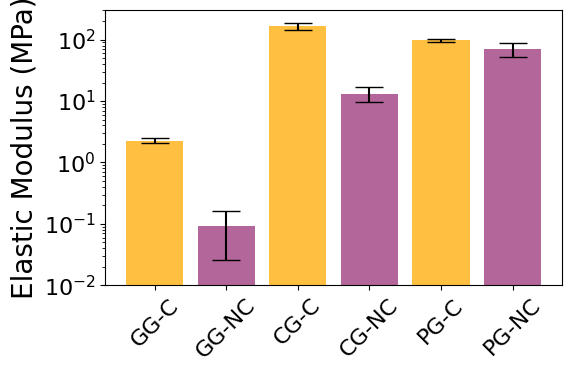

In [8]:
# Create a combined Specimen-Conductivity identifier for clarity in plotting
labels = [f"{label_dict[specimen]}-{label_dict[conductivity]}" for specimen, conductivity in zip(elastic_modulus_stats['Specimen'],elastic_modulus_stats['Conductivity'])]



plt.figure(figsize=(6, 4))

colors = [ (1,0.75,0.25), (0.7,0.4,0.6)]

errors = elastic_modulus_stats['std'].fillna(0)  # Replace NaN with 0 for plotting
plt.bar(labels, elastic_modulus_stats['mean'], bottom=0.01, yerr=errors, capsize=10, color=colors*3)
plt.yscale('log')
#plt.xlabel('Specimen-Conductivity')
plt.ylabel('Elastic Modulus (MPa)', fontsize=20)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("elasticmodulus.pdf")
plt.show()




In [9]:
def find_strain_at_break(group):
    max_stress = group['Stress'].max()
    half_max_stress = max_stress / 2
    below_half_max = group[group['Stress'] < half_max_stress]

    return group['Strain'].max()

# Apply the function and create a new DataFrame for strain at break values
strain_at_break_df = combined_data.groupby(['Specimen', 'Conductivity', 'SampleNumber']).apply(find_strain_at_break).reset_index(name='StrainAtBreak')

# Now, if you need to add 'StrainAtBreak' to the original DataFrame, ensure it's properly aligned or merged. Here's how to merge:
combined_data = pd.merge(combined_data, strain_at_break_df, on=['Specimen', 'Conductivity', 'SampleNumber'], how='left')

# Then, you can proceed with the calculation of stats for plotting:
strain_at_break_stats = strain_at_break_df.groupby(['Specimen', 'Conductivity'])['StrainAtBreak'].agg(['mean', 'std']).reset_index()


/tmp/ipykernel_8617/3397828444.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  strain_at_break_df = combined_data.groupby(['Specimen', 'Conductivity', 'SampleNumber']).apply(find_strain_at_break).reset_index(name='StrainAtBreak')


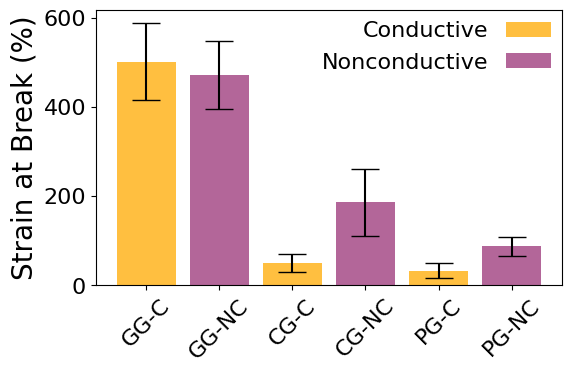

In [10]:
plt.figure(figsize=(6, 4))
# Assuming 'Specimen-Conductivity' as the x-axis

plt.bar(labels, strain_at_break_stats['mean']*100, yerr=strain_at_break_stats['std']*100, capsize=10, color=colors)

features = ['Conductive', 'Nonconductive']
for c,l in zip(colors, features):
    plt.bar([1],[1], color = c, label=l)#dummy bar for lagend
plt.legend(loc="upper right", fontsize=16, borderpad=0, frameon=False, markerfirst=False)

#plt.xlabel('Specimen-Conductivity')
plt.ylabel('Strain at Break (%)', fontsize=20)
plt.xticks(rotation=45)  # Useful if the labels are long
plt.tight_layout()
plt.savefig("strainatbreak.pdf")
plt.show()


In [11]:
strain_at_break_stats

,Specimen,Conductivity,mean,std
0,g60,conductive,5.016455,0.861410
1,g60,nonconductive,4.714212,0.753029
2,hmwg,conductive,0.499052,0.201474
3,hmwg,nonconductive,1.860103,0.757475
4,pristine,conductive,0.332588,0.170087
5,pristine,nonconductive,0.871674,0.219339
